In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
df = pd.read_csv("Adidas US Sales.csv", delimiter=";", low_memory=False)
df = df[['sales_id', 'retailer', 'retailer_id', 'invoice_date', 'region', 'state', 'city', 'product', 'price_per_unit', 'units_sold', 'total_sales', 'operating_profit', 'sales_method']]
missing_before = df.isnull().sum()
total_missing_before = missing_before.sum()
print("Количество пустых значений до очистки по столбцам:")
print(missing_before)
print(f"\nВсего пустых значений до очистки: {total_missing_before}")

rows_before = df.shape[0]

df = df.dropna()

rows_after = df.shape[0]

missing_after = df.isnull().sum()
total_missing_after = missing_after.sum()

print("\nКоличество пустых значений после очистки по столбцам:")
print(missing_after)
print(f"\nВсего пустых значений после очистки: {total_missing_after}")
print(f"\nУдалено строк: {rows_before - rows_after}")
print(f"Количество строк после очистки: {rows_after}")
print(f"Доля удалённых строк: {((rows_before - rows_after) / rows_before) * 100:.2f}%")


Количество пустых значений до очистки по столбцам:
sales_id            0
retailer            0
retailer_id         0
invoice_date        0
region              0
state               0
city                0
product             0
price_per_unit      0
units_sold          0
total_sales         0
operating_profit    0
sales_method        0
dtype: int64

Всего пустых значений до очистки: 0

Количество пустых значений после очистки по столбцам:
sales_id            0
retailer            0
retailer_id         0
invoice_date        0
region              0
state               0
city                0
product             0
price_per_unit      0
units_sold          0
total_sales         0
operating_profit    0
sales_method        0
dtype: int64

Всего пустых значений после очистки: 0

Удалено строк: 0
Количество строк после очистки: 9637
Доля удалённых строк: 0.00%


In [7]:
df.head()

,sales_id,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
0,1,Foot Locker,1185732,06.11.2021,Southeast,South Carolina,Charleston,Men's Street Footwear,50,278,13900,792,Online
1,2,Foot Locker,1185732,14.03.2020,Northeast,New York,New York,Men's Apparel,46,278,12788,435,Outlet
2,3,West Gear,1128299,19.01.2021,West,California,San Francisco,Men's Athletic Footwear,47,278,13066,287,Outlet
3,4,Walmart,1128299,17.06.2021,Southeast,Florida,Orlando,Women's Apparel,103,218,22454,1257,Online
4,5,Sports Direct,1197831,14.09.2021,South,Alabama,Birmingham,Women's Street Footwear,36,278,10008,530,Outlet


In [8]:
df.shape

(9637, 13)

In [9]:
df.columns

Index(['sales_id', 'retailer', 'retailer_id', 'invoice_date', 'region',
       'state', 'city', 'product', 'price_per_unit', 'units_sold',
       'total_sales', 'operating_profit', 'sales_method'],
      dtype='object')

In [10]:
df.dtypes

sales_id             int64
retailer            object
retailer_id          int64
invoice_date        object
region              object
state               object
city                object
product             object
price_per_unit       int64
units_sold           int64
total_sales          int64
operating_profit     int64
sales_method        object
dtype: object

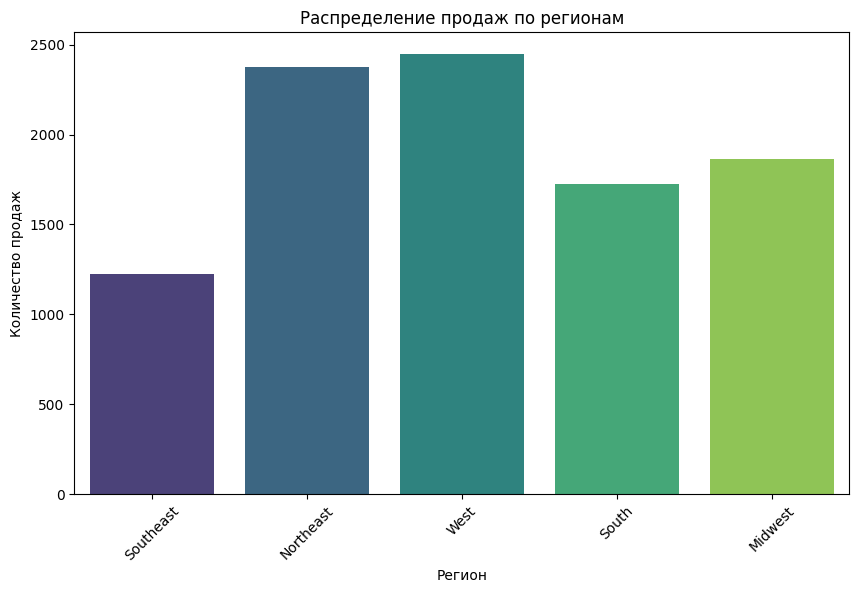

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='region', hue='region', palette='viridis', legend=False)
plt.title('Распределение продаж по регионам')
plt.xlabel('Регион')
plt.ylabel('Количество продаж')
plt.xticks(rotation=45)
plt.show()

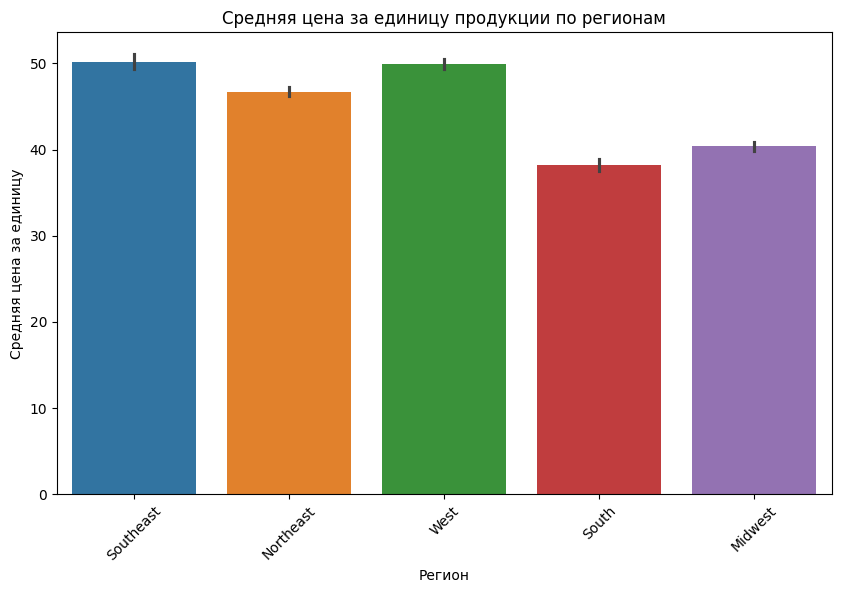

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='region', y='price_per_unit', estimator='mean', hue='region', legend=False)
plt.title('Средняя цена за единицу продукции по регионам')
plt.xlabel('Регион')
plt.ylabel('Средняя цена за единицу')
plt.xticks(rotation=45)
plt.show()

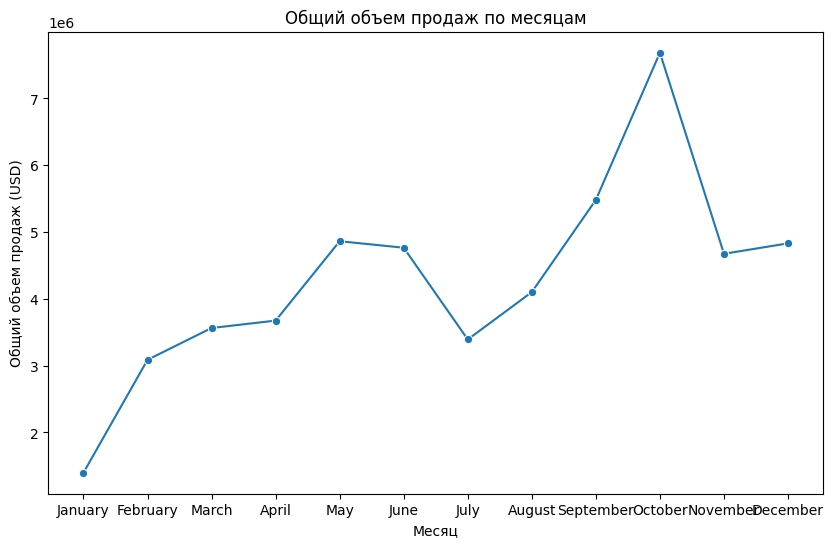

In [13]:
import calendar

df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce')
df['month'] = df['invoice_date'].dt.month

monthly_sales = df.groupby('month')['total_sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales, x='month', y='total_sales', marker="o")
plt.title('Общий объем продаж по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Общий объем продаж (USD)')
plt.xticks(ticks=range(1, 13), labels=[calendar.month_name[i] for i in range(1, 13)])
plt.show()

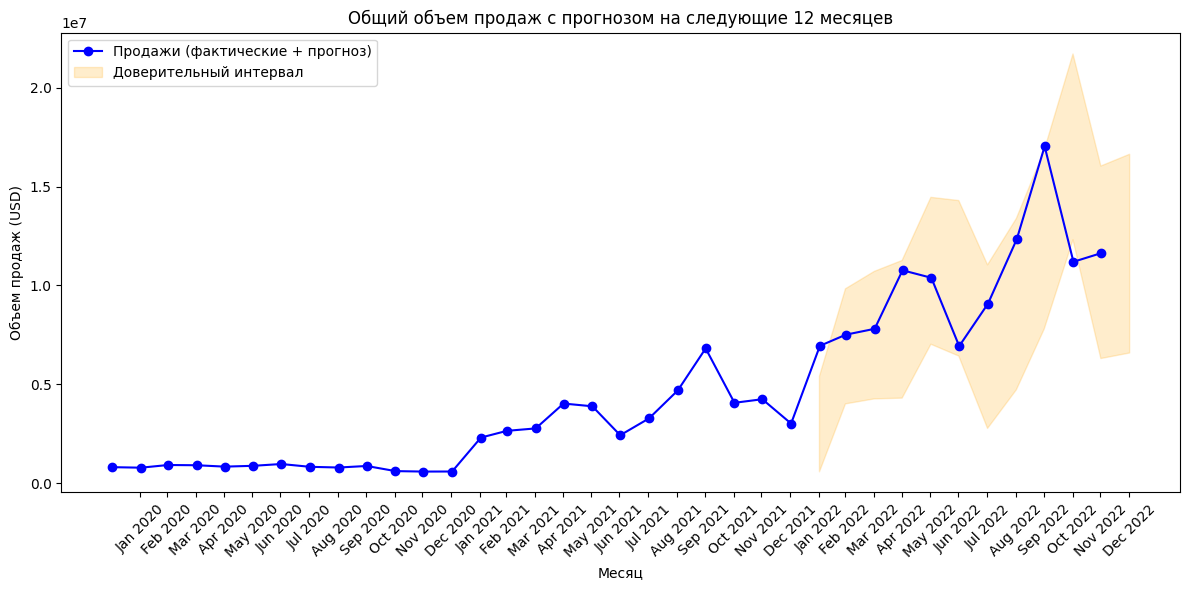

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import calendar
import warnings

warnings.filterwarnings("ignore")

df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce')
df['month'] = df['invoice_date'].dt.to_period('M')

monthly_sales = df.groupby('month')['total_sales'].sum()
monthly_sales.index = monthly_sales.index.to_timestamp()

model = SARIMAX(monthly_sales, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model = model.fit(disp=False)

forecast = sarima_model.get_forecast(steps=12)
forecast_index = pd.date_range(monthly_sales.index[-1] + pd.offsets.MonthBegin(), periods=12, freq='M')
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

all_sales = pd.concat([monthly_sales, forecast_values])
all_conf_int = pd.concat([forecast_conf_int], keys=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(all_sales.index, all_sales, label='Продажи (фактические + прогноз)', marker="o", color='blue')
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='orange', alpha=0.2, label='Доверительный интервал')

plt.title('Общий объем продаж с прогнозом на следующие 12 месяцев')
plt.xlabel('Месяц')
plt.ylabel('Объем продаж (USD)')
plt.xticks(
    ticks=pd.date_range(start=monthly_sales.index[0], end=forecast_index[-1], freq='M'),
    labels=[calendar.month_abbr[date.month] + " " + str(date.year) for date in pd.date_range(start=monthly_sales.index[0], end=forecast_index[-1], freq='M')],
    rotation=45
)
plt.legend()
plt.tight_layout()
plt.show()


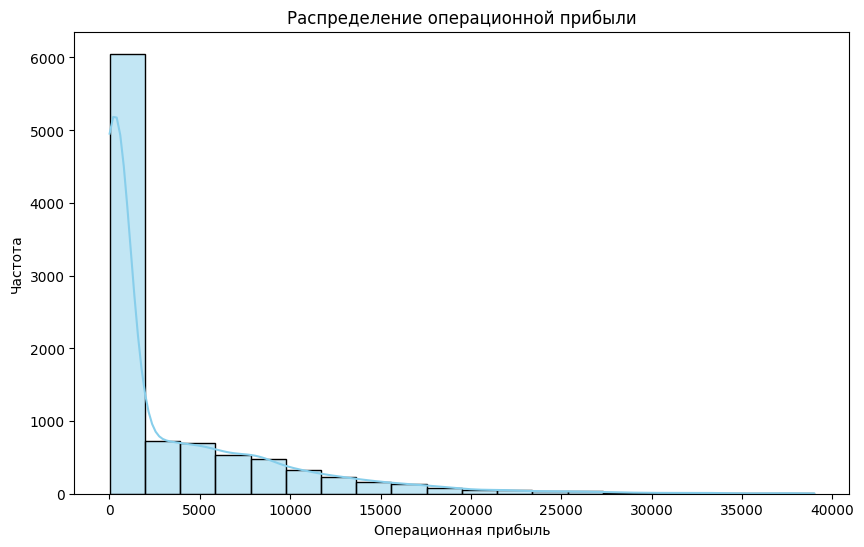

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df['operating_profit'], bins=20, kde=True, color='skyblue')
plt.title('Распределение операционной прибыли')
plt.xlabel('Операционная прибыль')
plt.ylabel('Частота')
plt.show()

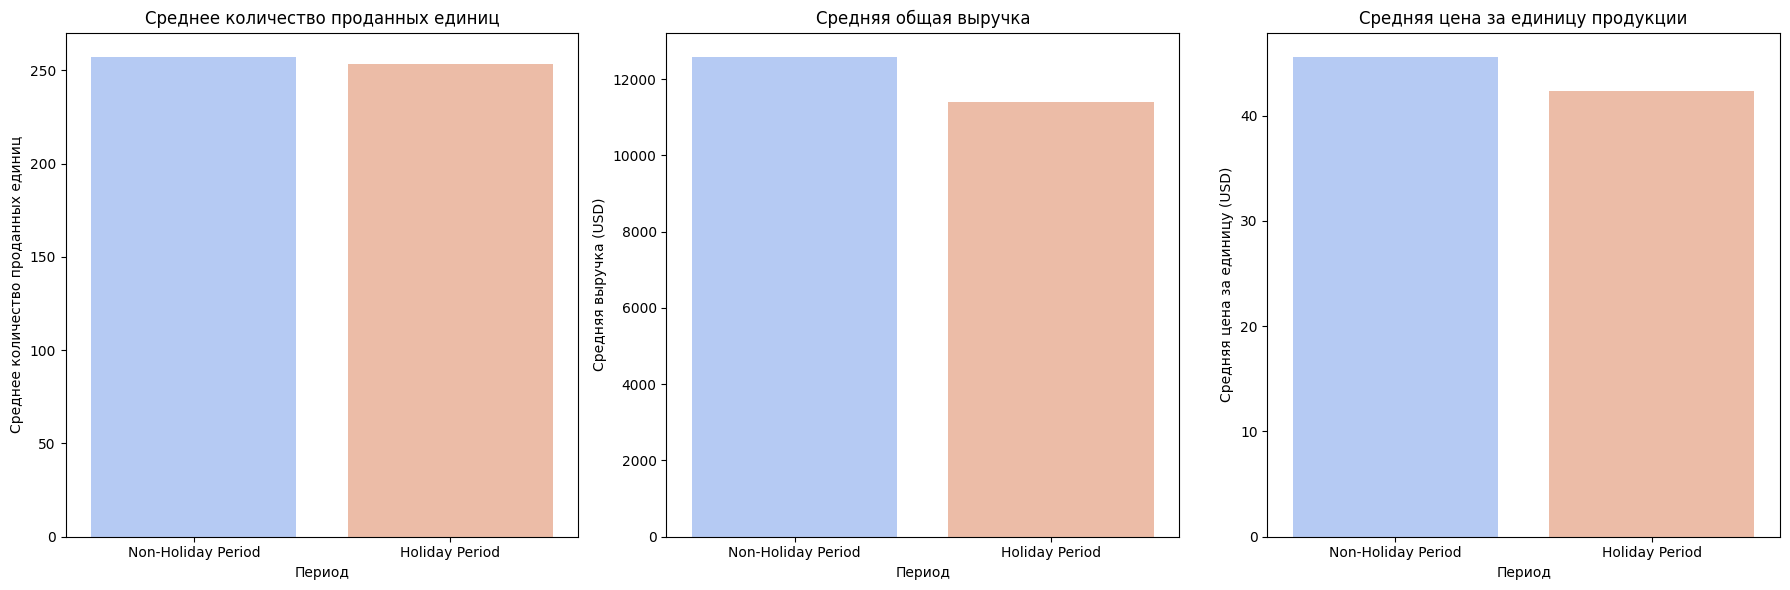

In [16]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce')

df['is_holiday_period'] = df['invoice_date'].dt.month.isin([7, 11, 12])

holiday_data = df.groupby('is_holiday_period').agg({
    'units_sold': 'mean',
    'total_sales': 'mean',
    'price_per_unit': 'mean'
}).reset_index()

holiday_data['is_holiday_period'] = holiday_data['is_holiday_period'].map({True: 'Holiday Period', False: 'Non-Holiday Period'})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(data=holiday_data, x='is_holiday_period', y='units_sold', hue='is_holiday_period', palette='coolwarm', ax=axes[0], legend=False)
axes[0].set_title('Среднее количество проданных единиц')
axes[0].set_xlabel('Период')
axes[0].set_ylabel('Среднее количество проданных единиц')

sns.barplot(data=holiday_data, x='is_holiday_period', y='total_sales', hue='is_holiday_period', palette='coolwarm', ax=axes[1], legend=False)
axes[1].set_title('Средняя общая выручка')
axes[1].set_xlabel('Период')
axes[1].set_ylabel('Средняя выручка (USD)')

sns.barplot(data=holiday_data, x='is_holiday_period', y='price_per_unit', hue='is_holiday_period', palette='coolwarm', ax=axes[2], legend=False)
axes[2].set_title('Средняя цена за единицу продукции')
axes[2].set_xlabel('Период')
axes[2].set_ylabel('Средняя цена за единицу (USD)')

plt.tight_layout()
plt.show()


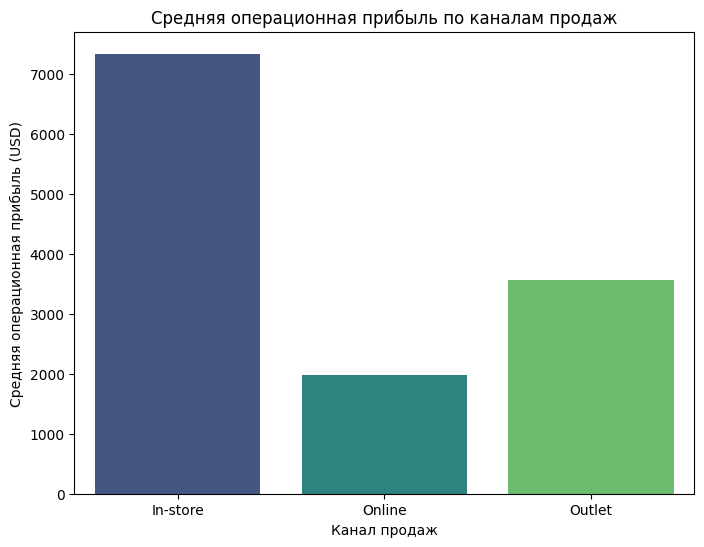

In [17]:
profit_data = df.groupby('sales_method')['operating_profit'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=profit_data, x='sales_method', y='operating_profit', hue='sales_method', palette='viridis', legend=False)
plt.title('Средняя операционная прибыль по каналам продаж')
plt.xlabel('Канал продаж')
plt.ylabel('Средняя операционная прибыль (USD)')
plt.show()

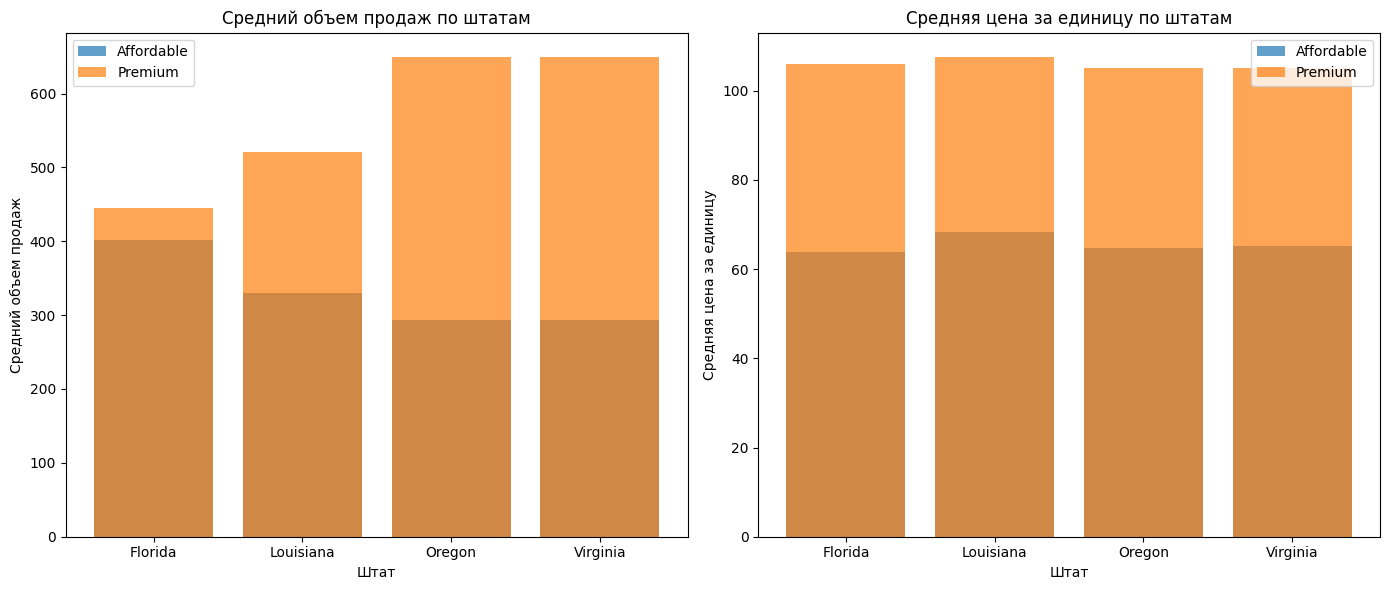

In [23]:
adidas_sales = pd.read_csv('Adidas US Sales.csv', delimiter=';')

affordable_range = (50, 100)
premium_threshold = 100

affordable_products = adidas_sales[(adidas_sales['price_per_unit'] >= affordable_range[0]) & 
                                   (adidas_sales['price_per_unit'] <= affordable_range[1])]
premium_products = adidas_sales[adidas_sales['price_per_unit'] > premium_threshold]

affordable_summary = affordable_products.groupby('state').agg(
    avg_units_sold=('units_sold', 'mean'),
    avg_price_per_unit=('price_per_unit', 'mean')
).reset_index()

premium_summary = premium_products.groupby('state').agg(
    avg_units_sold=('units_sold', 'mean'),
    avg_price_per_unit=('price_per_unit', 'mean')
).reset_index()

merged_summary = pd.merge(affordable_summary, premium_summary, on='state', 
                          suffixes=('_affordable', '_premium'))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(merged_summary['state'], merged_summary['avg_units_sold_affordable'], label='Affordable', alpha=0.7)
axes[0].bar(merged_summary['state'], merged_summary['avg_units_sold_premium'], label='Premium', alpha=0.7)
axes[0].set_title('Средний объем продаж по штатам')
axes[0].set_xlabel('Штат')
axes[0].set_ylabel('Средний объем продаж')
axes[0].legend()

axes[1].bar(merged_summary['state'], merged_summary['avg_price_per_unit_affordable'], label='Affordable', alpha=0.7)
axes[1].bar(merged_summary['state'], merged_summary['avg_price_per_unit_premium'], label='Premium', alpha=0.7)
axes[1].set_title('Средняя цена за единицу по штатам')
axes[1].set_xlabel('Штат')
axes[1].set_ylabel('Средняя цена за единицу')
axes[1].legend()

plt.tight_layout()
plt.show()


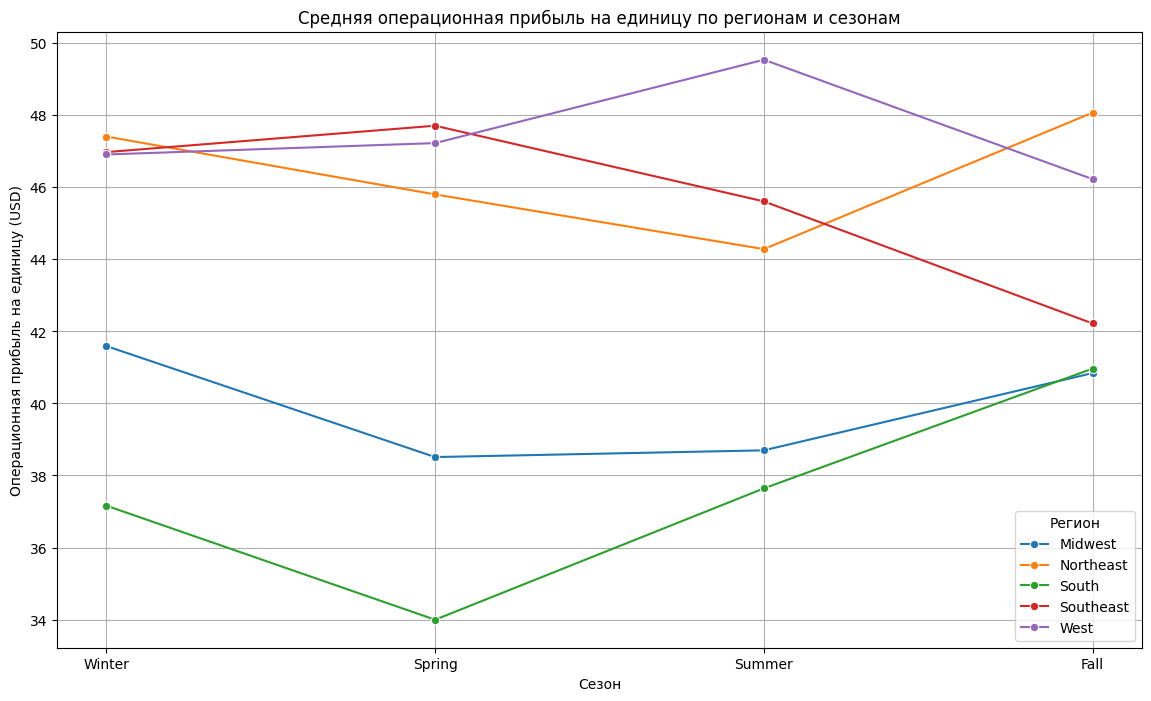

In [25]:
df['season'] = df['invoice_date'].dt.month.map({
       12: 'Winter', 1: 'Winter', 2: 'Winter',
       3: 'Spring', 4: 'Spring', 5: 'Spring',
       6: 'Summer', 7: 'Summer', 8: 'Summer',
       9: 'Fall', 10: 'Fall', 11: 'Fall'
   })
   
df['profit_per_unit'] = df['total_sales'] / df['units_sold']
   


profit_by_region_season = df.groupby(['region', 'season']).agg({
    'profit_per_unit': 'mean'
}).reset_index()

season_order = ["Winter", "Spring", "Summer", "Fall"]
profit_by_region_season['season'] = pd.Categorical(profit_by_region_season['season'], categories=season_order, ordered=True)

plt.figure(figsize=(14, 8))
sns.lineplot(data=profit_by_region_season, x='season', y='profit_per_unit', hue='region', marker='o', palette='tab10')

plt.title('Средняя операционная прибыль на единицу по регионам и сезонам')
plt.xlabel('Сезон')
plt.ylabel('Операционная прибыль на единицу (USD)')
plt.legend(title='Регион')
plt.grid(True)
plt.show()



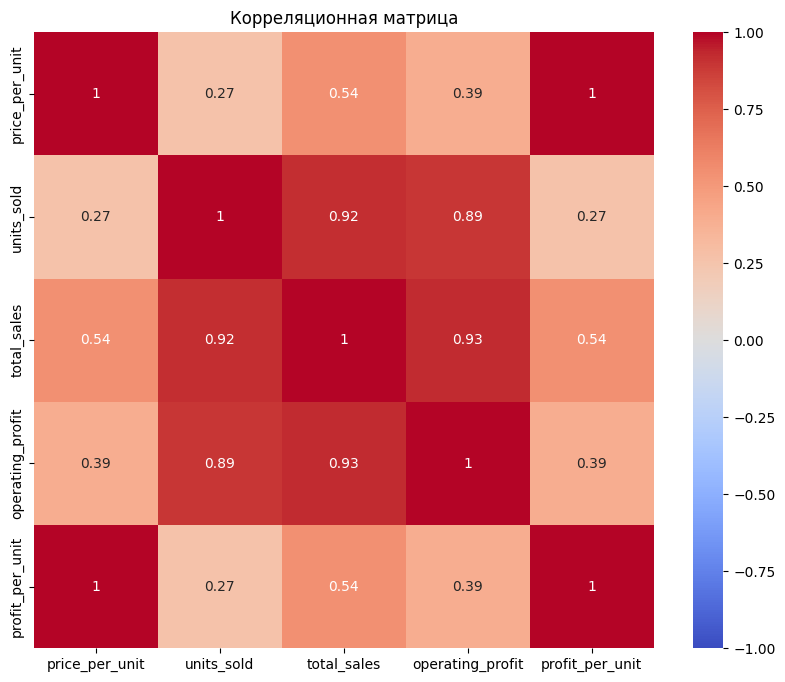

In [26]:
numeric_cols = ['price_per_unit', 'units_sold', 'total_sales', 'operating_profit', 'profit_per_unit']
numeric_data = df[numeric_cols]

correlation_matrix = numeric_data.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Корреляционная матрица")
plt.show()


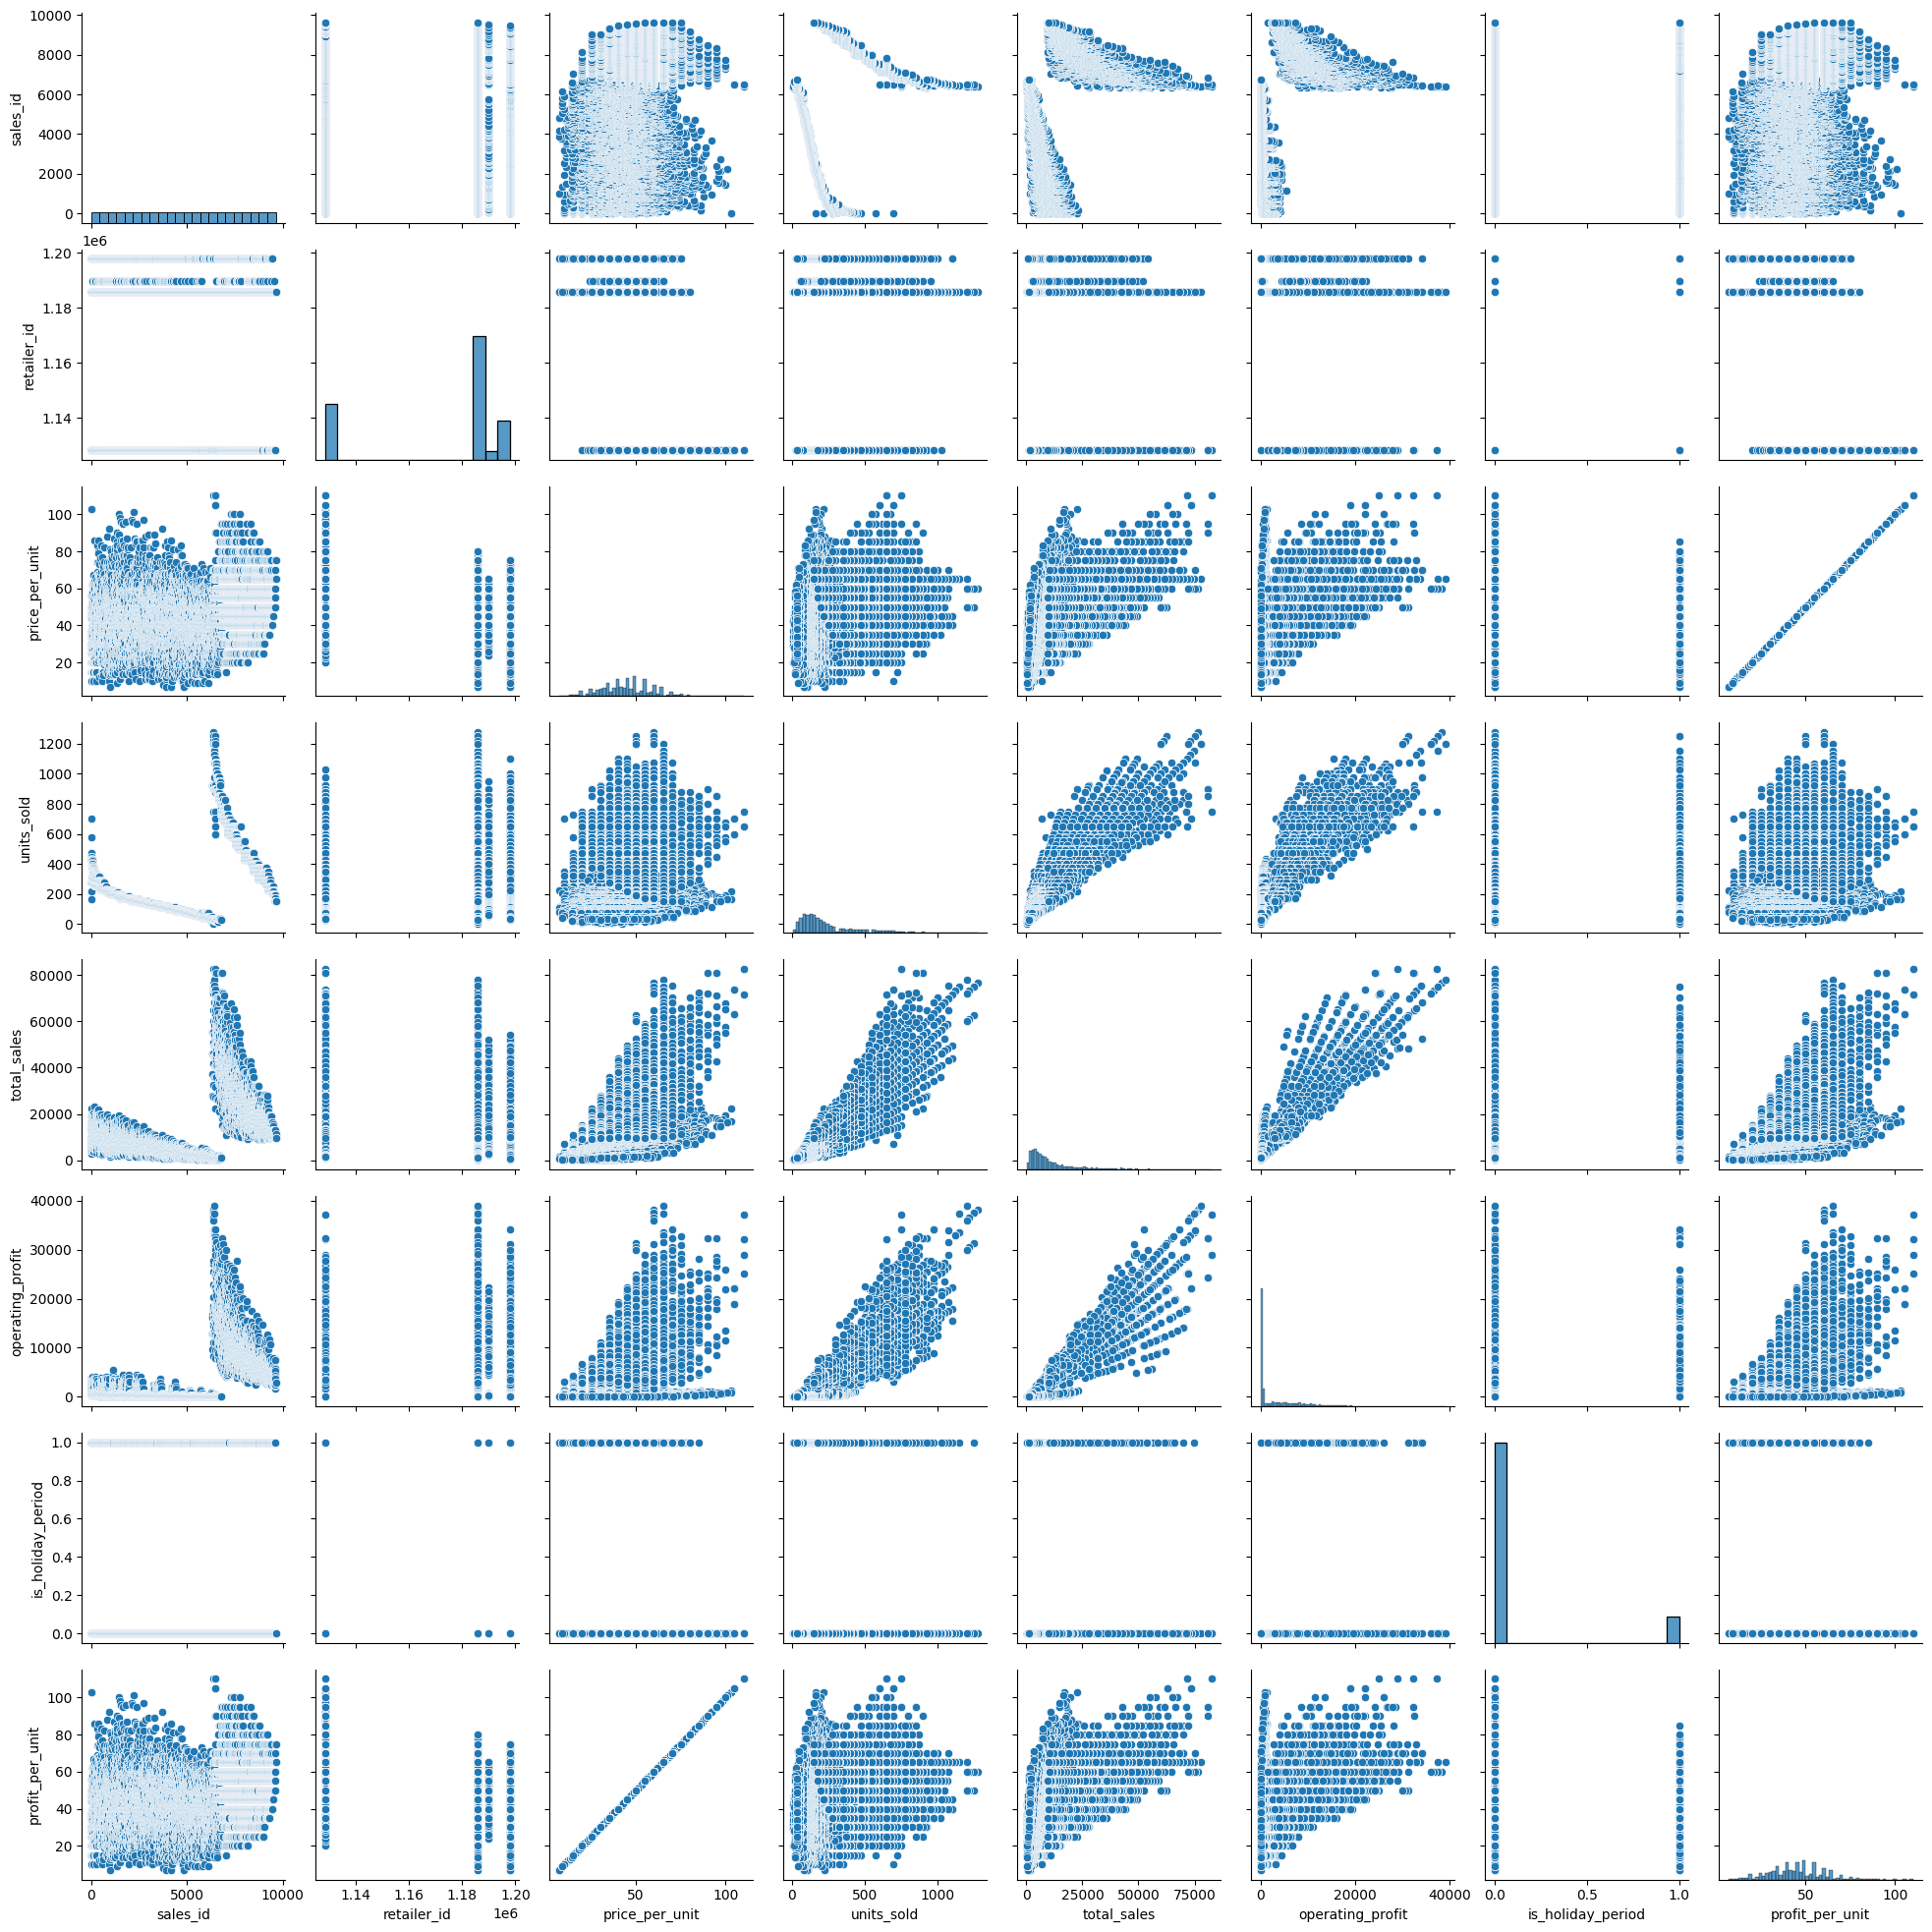

In [27]:
sns.pairplot(df)